In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform


In [44]:
df = pd.read_csv("data/destinations.csv", encoding="ISO-8859-1")


df_geo = df[["Latitude", "Longitude"]].dropna()

print("Total de destinos:", len(df_geo))
df_geo.head()

scaler = StandardScaler()
X_std = scaler.fit_transform(df_geo.values)



Total de destinos: 209


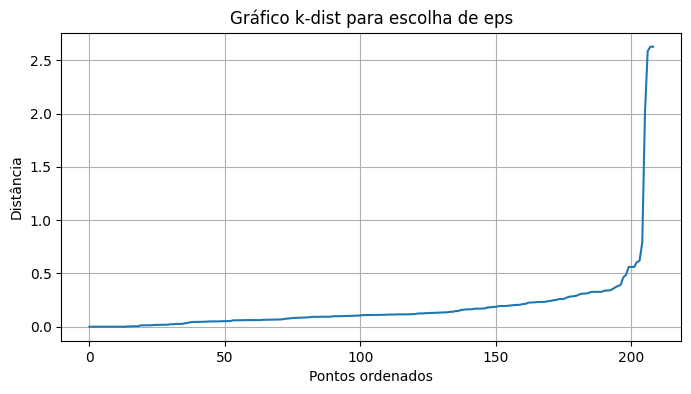

In [50]:
from sklearn.neighbors import NearestNeighbors


neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_std)
distances, indices = neighbors_fit.kneighbors(X_std)
distances = np.sort(distances[:, 3])

plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title("Gráfico k-dist para escolha de eps")
plt.xlabel("Pontos ordenados")
plt.ylabel("Distância")
plt.grid(True)
plt.show()


In [48]:
eps_value = 0.45   # escolha após olhar o gráfico
min_samples_value = 5

db = DBSCAN(eps=eps_value, min_samples=min_samples_value)
labels = db.fit_predict(X_std)

print("Clusters encontrados:", set(labels))



Clusters encontrados: {np.int64(0), np.int64(1), np.int64(2), np.int64(-1)}


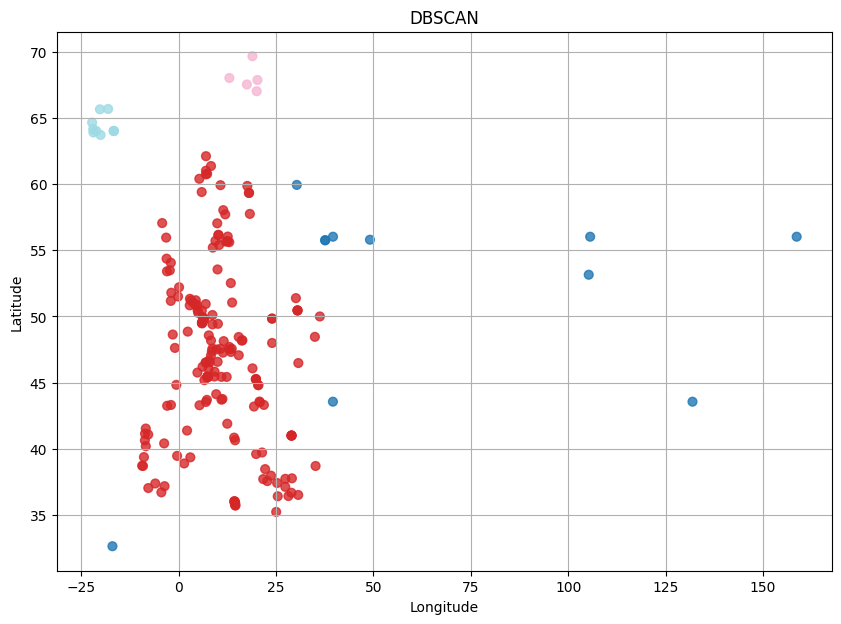

In [49]:

plt.figure(figsize=(10,7))

plt.scatter(df_geo["Longitude"], df_geo["Latitude"], 
            c=labels, cmap="tab20", s=40, alpha=0.8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"DBSCAN")
plt.grid(True)
plt.show()

